In [8]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization



from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Input
from tensorflow.keras.models import Model


# Chemins des données
benign_path = "//kaggle/input/breastcancermasses/Dataset of Mammography with Benign Malignant Breast Masses/Dataset of Mammography with Benign Malignant Breast Masses/INbreast+MIAS+DDSM Dataset/Benign Masses"
malignant_path = "/kaggle/input/breastcancermasses/Dataset of Mammography with Benign Malignant Breast Masses/Dataset of Mammography with Benign Malignant Breast Masses/INbreast+MIAS+DDSM Dataset/Malignant Masses"






In [9]:
# Fonction pour charger et prétraiter les images
def get_file_paths_and_labels(directory, label):
    file_paths = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith((".png", ".jpg", ".jpeg"))]
    labels = [label] * len(file_paths)
    return file_paths, labels


In [10]:
# Charger les chemins et les labels
benign_file_paths, benign_labels = get_file_paths_and_labels(benign_path, 0)
malignant_file_paths, malignant_labels = get_file_paths_and_labels(malignant_path, 1)

In [11]:
# Fusionner les chemins et labels
file_paths = benign_file_paths + malignant_file_paths
labels = benign_labels + malignant_labels



In [12]:
# Diviser les données en train, validation et test
X_train, X_temp, y_train, y_temp = train_test_split(file_paths, labels, test_size=0.4, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)



In [13]:
# Fonction de prétraitement 
def preprocess_image(file_path, label):
    try:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, [227, 227])
        img = img / 255.0
        return img, label
    except Exception as e:
        print(f"Erreur lors du traitement du fichier : {file_path}. Erreur : {e}")
        return tf.zeros([227, 227, 3]), label


 
def create_dataset(file_paths, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(file_paths))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset




In [14]:
# Créer les datasets d'entraînement, validation , test
batch_size = 32
train_dataset = create_dataset(X_train, y_train, batch_size=batch_size)
val_dataset = create_dataset(X_val, y_val, batch_size=batch_size, shuffle=False)
test_dataset = create_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)



In [18]:


# Définition du modèle CNN
model = Sequential([
    
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(227, 227, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') 
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 227, 227, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 227, 227, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 113, 113, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 113, 113, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 113, 113, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │      25,690,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,212,545 (99.99 MB)

 Trainable params: 26,211,585 (99.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [19]:


# Compiler le modèle
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Entraîner le modèle
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)




Epoch 1/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 83s 109ms/step - accuracy: 0.5737 - loss: 4.6599 - val_accuracy: 0.6191 - val_loss: 0.6127
Epoch 2/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 44s 75ms/step - accuracy: 0.7358 - loss: 0.5371 - val_accuracy: 0.8053 - val_loss: 0.3955
Epoch 3/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 46s 77ms/step - accuracy: 0.7734 - loss: 0.4529 - val_accuracy: 0.8317 - val_loss: 0.3320
Epoch 4/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 45s 78ms/step - accuracy: 0.8051 - loss: 0.3865 - val_accuracy: 0.8287 - val_loss: 0.3898
Epoch 5/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 46s 79ms/step - accuracy: 0.8056 - loss: 0.3736 - val_accuracy: 0.8136 - val_loss: 0.3359
Epoch 6/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 46s 79ms/step - accuracy: 0.8009 - loss: 0.3694 - val_accuracy: 0.7984 - val_loss: 0.3543
Epoch 7/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 47s 80ms/step - accuracy: 0.8132 - loss: 0.3517 - val_accuracy: 0.7998 - val_loss: 0.3306
Epoch 8/20
461/461 ━━━━━━━━━━━━━━━━━━━━ 47s 79ms/step - accuracy: 0.8162 - loss: 0.3430 -

In [20]:
# Évaluer sur le dataset de test
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.2f}")



154/154 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.8548 - loss: 0.3061
Test Accuracy: 0.85


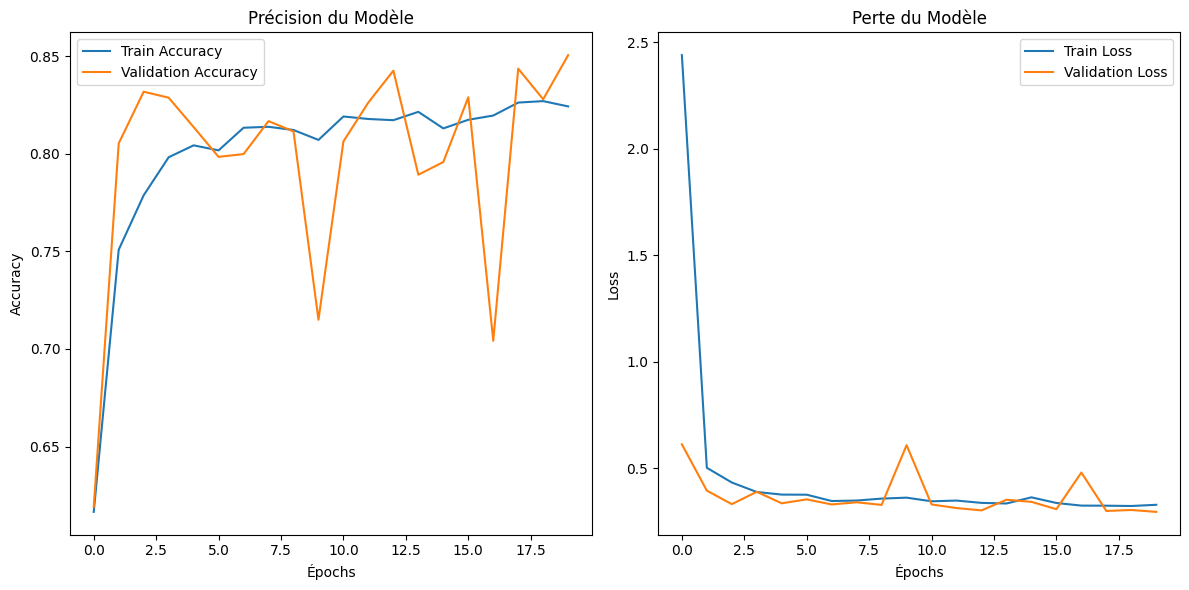

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

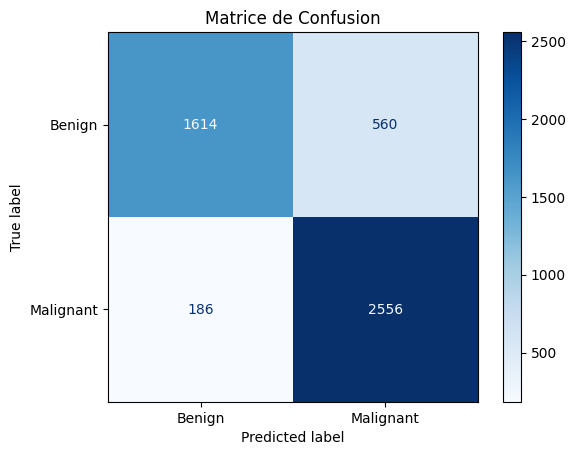

In [21]:

# 1. Afficher les courbes de précision et de perte
def plot_training_history(history):
    # Précision
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Précision du Modèle')
    plt.xlabel('Épochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Perte
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Perte du Modèle')
    plt.xlabel('Épochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 2. Calculer et afficher la matrice de confusion
def plot_confusion_matrix(model, test_dataset):
    # Prédictions et vrais labels
    y_true = []
    y_pred = []
    for images, labels in test_dataset:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.round(preds).flatten())  

    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Matrice de Confusion")
    plt.show()

plot_training_history(history)
plot_confusion_matrix(model, test_dataset)
